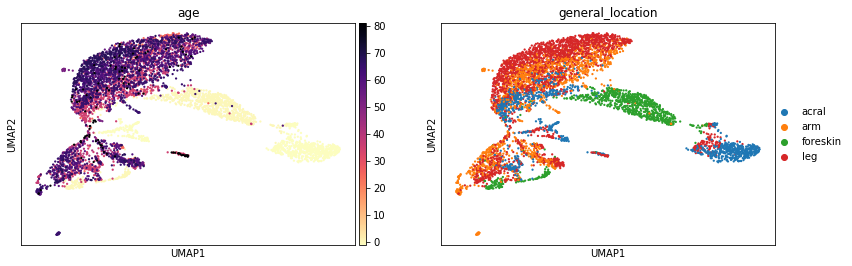

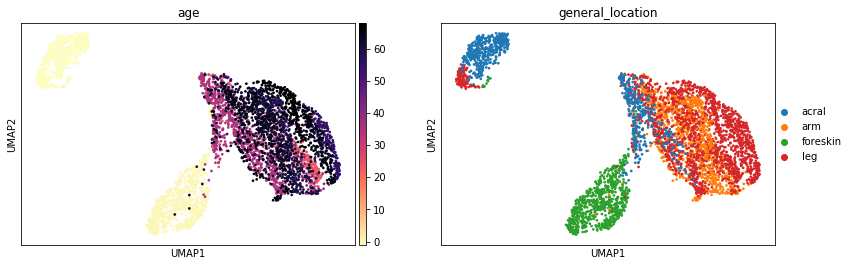

Completed


In [1]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT','raw_adata']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')

In [2]:
%%capture
###############################################
###############################################
# Compute union of differentially expressed gene among samples
# This chuck returns a dataframe of DE genes found in all samples
###############################################
###############################################

# Specify patients of interest
patientOIs = ['12WKM01', 'A1038LM']

# Specify feature to compare
groupby = 'louvain'

# Specify the number of top DE genes per test
n_genes = 50

###############################################

ranks_dict = {}
for idx, patientOI in enumerate(patientOIs):
    exec(f'global adata_{patientOI}')
    input_adata = adata_subset2
    patients = list(set(input_adata.obs.patient))
    type_dict = {'in':[patientOI],
                 'out':[x for x in patients if x != patientOI]}

    classify_type(raw_adata, input_adata, 'patient', type_dict, 'class_3')

    feature_dict = {'class_3':['in']}
    adata_subset3 = subset_adata_v3(raw_adata,feature_dict)
    adata_subset3 = process_adata(adata_subset3)
    pca_adata(adata_subset3, num_pcs=30)
    umap_adata(adata_subset3, res=0.2)
    sc.pl.umap(adata_subset3, color=['louvain','general_location'])

    exec(f'adata_{patientOI} = input_adata = adata_subset3')
    ranks_df = simple_rank (input_adata, groupby=groupby, n_genes=n_genes)
    ranks_df['patient'] = patientOI
    ranks_dict[patientOI] = ranks_df


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_3' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_3' as categorical


12WKM01


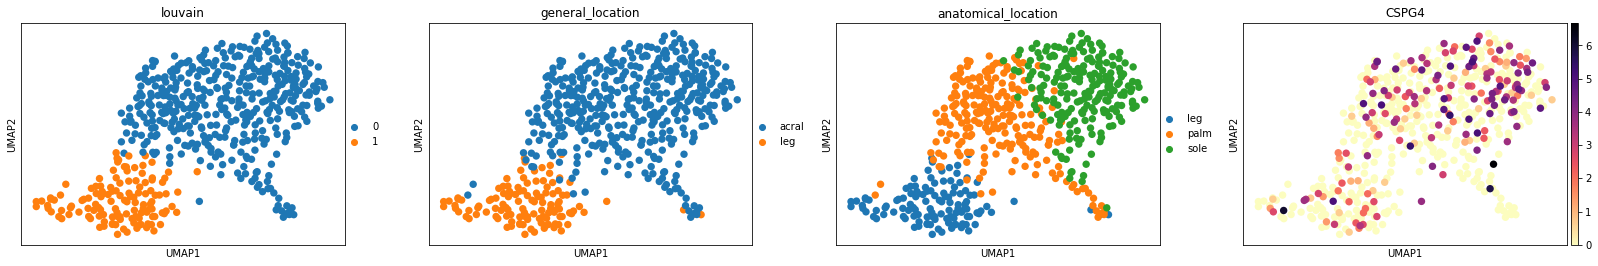

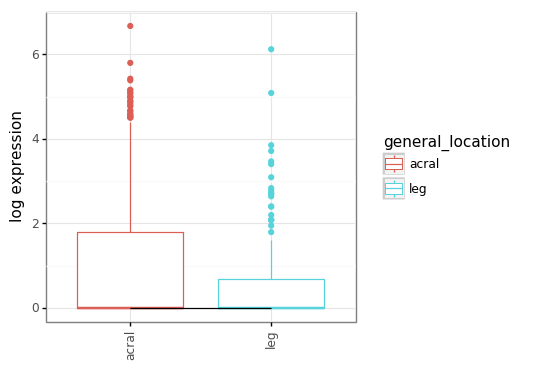

<ggplot: (-9223363248454401213)>


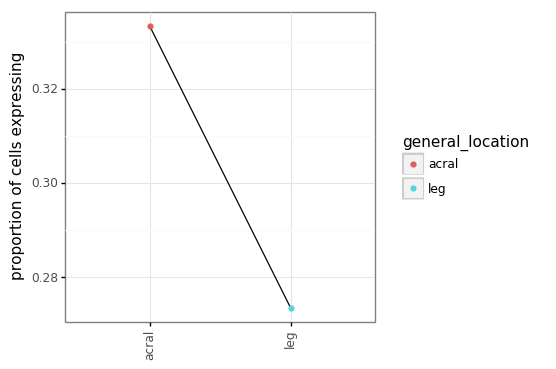

<ggplot: (-9223363248454427455)>
A1038LM


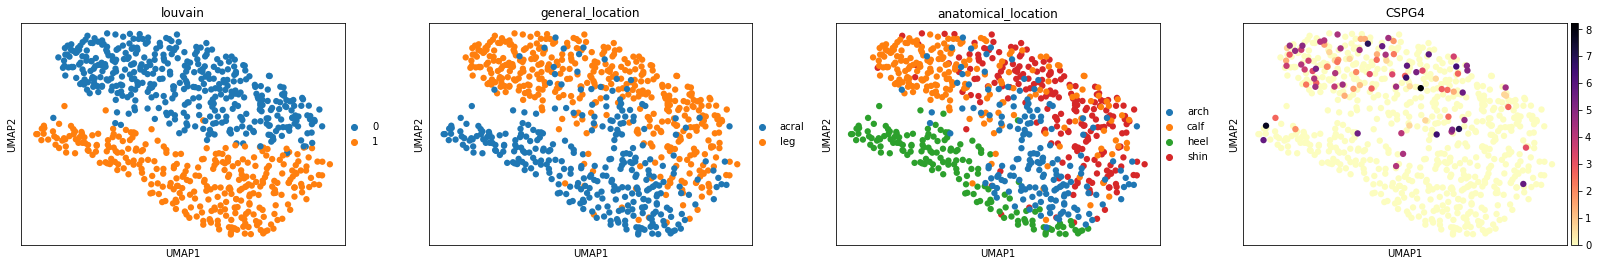

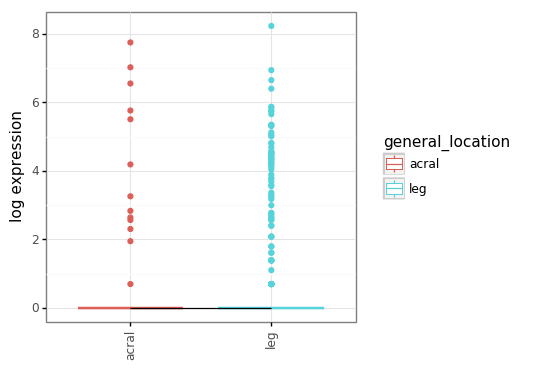

<ggplot: (8788435856276)>


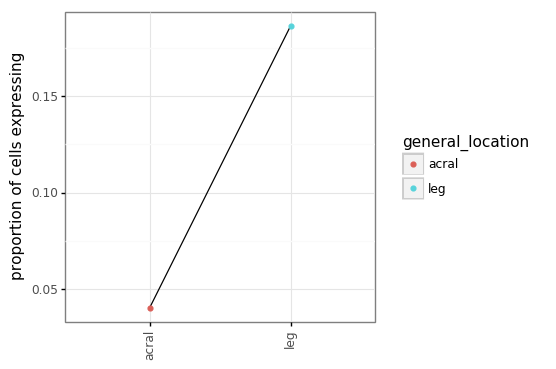

<ggplot: (8788433934088)>
querying 1-1...done.
Finished.
0:  CSPG4 
 A human melanoma-associated chondroitin sulfate proteoglycan plays a role in stabilizing cell-substratum interactions during early events of melanoma cell spreading on endothelial basement membranes. CSPG4 represents an integral membrane chondroitin sulfate proteoglycan expressed by human malignant melanoma cells. [provided by RefSeq, Jul 2008].


In [3]:
###############################################
###############################################
# Visualize clustering
# This chuck displays UMAPS
###############################################
###############################################

# Specify patients of interest
patientOIs = ['12WKM01', 'A1038LM']

# Specify gene of interest
geneOI = 'CSPG4'

# Specify grouping for expression analysis
groupby = 'general_location'

###############################################

for idx, patientOI in enumerate(patientOIs):
    print(patientOI)
    exec(f'sc.pl.umap(adata_{patientOI}, color=["louvain","general_location","anatomical_location","{geneOI}"], cmap = "magma_r")')
    
    input_adata = eval(f'adata_{patientOI}')
    gene2plots(input_adata, geneOI, groupby)
    
out = symbol2field(geneOI)
output = [print(f'{idx}: ',
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]
   

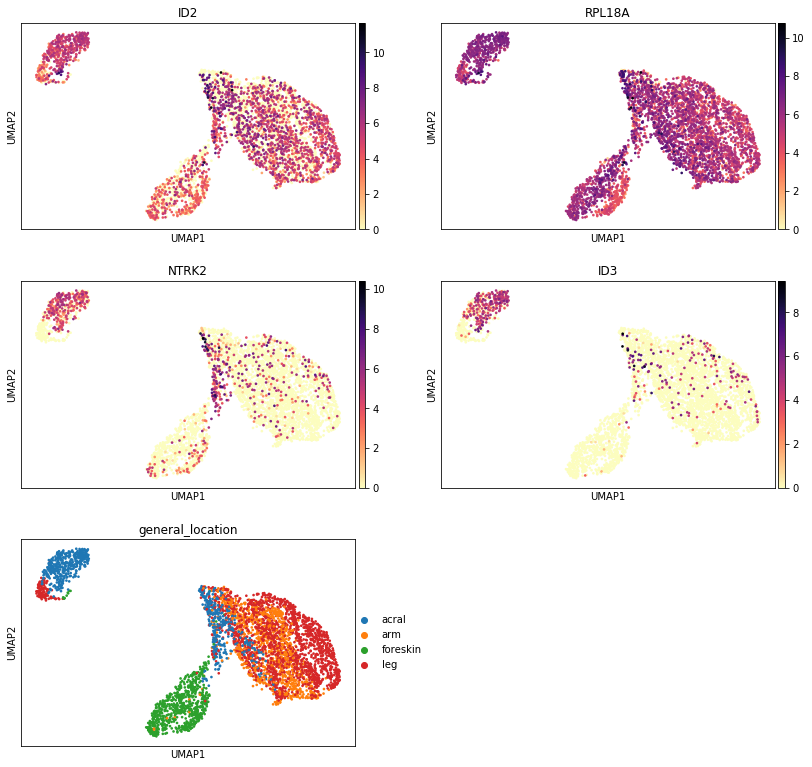

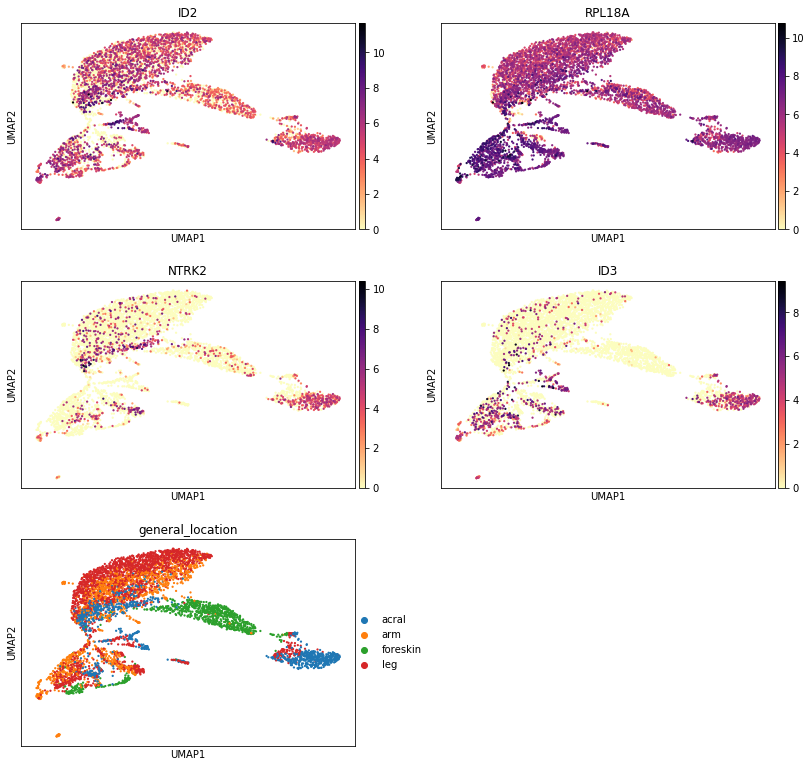

querying 1-4...done.
Finished.


In [14]:
###############################################
###############################################
# Display summary of DE genes found in all samples
# This chuck displays MEL and all-cells UMAPS and gene annotations
###############################################
###############################################

# Specify patients and feature group
patient2feature = {'12WKM01':'0',
                   'A1038LM':'1'}

###############################################

full_list = []
for key,value in patient2feature.items():
    list_iter = list(set(ranks_dict[key][value].values.tolist()))
    full_list = full_list + list_iter

union_df = pd.DataFrame({'genes':full_list})['genes'].value_counts()
genes = union_df[union_df > 1].index.tolist()
sc.pl.umap(adata_subset2, color=genes+['general_location'], ncols = 2, cmap='magma_r')
sc.pl.umap(full_adata, color=genes+['general_location'], ncols = 2, cmap='magma_r')
out = symbol2field(genes)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = 'HSPD1'
output = [print(x) for x in full_report if search_term in x]
